# Appendix - Repeated evaluation w/full state observed

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import cf.counterfactual as cf
import cf.utils as utils
import pandas as pd
import pickle
import itertools as it
from tqdm import tqdm_notebook as tqdm
from scipy.linalg import block_diag

# Sepsis Simulator code
from sepsisSimDiabetes.State import State
from sepsisSimDiabetes.Action import Action
from sepsisSimDiabetes.DataGenerator import DataGenerator
import sepsisSimDiabetes.MDP as simulator 

import mdptoolboxSrc.mdp as mdptools

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Avoid Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

figpath = "./figs"

In [3]:
fig_prefix = "appendix-multiple-heldout-full-state-1k"

In [4]:
SEED = 1  # Note this is not the only random seed, see the loop

In [5]:
np.random.seed(SEED)
NSIMSAMPS = 1000  # Samples to draw from the simulator
NSTEPS = 20  # Max length of each trajectory
NCFSAMPS = 1  # Counterfactual Samples per observed sample
DISCOUNT_Pol = 0.99 # Used for computing optimal policies
DISCOUNT = 1 # Used for computing actual reward
PHYS_EPSILON = 0.05 # Used for sampling using physician pol as eps greedy

PROB_DIAB = 0.2

# Number of iterations to get error bars
N_REPEAT_SAMPLING = 100
NHELDOUT = 1000 # Heldout samples for WIS

# These are properties of the simulator, do not change
n_actions = Action.NUM_ACTIONS_TOTAL
n_components = 2

# These are added as absorbing states
# NOTE: Change to full states
n_states_abs = State.NUM_FULL_STATES + 2
discStateIdx = n_states_abs - 1
deadStateIdx = n_states_abs - 2

In [6]:
# Get the transition and reward matrix from file
with open("./data/diab_txr_mats-replication.pkl", "rb") as f:
    mdict = pickle.load(f)

tx_mat = mdict["tx_mat"]
r_mat = mdict["r_mat"]
p_mixture = np.array([1 - PROB_DIAB, PROB_DIAB])

In [7]:
from scipy.linalg import block_diag

tx_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))
r_mat_full = np.zeros((n_actions, State.NUM_FULL_STATES, State.NUM_FULL_STATES))

for a in range(n_actions):
    tx_mat_full[a, ...] = block_diag(tx_mat[0, a, ...], tx_mat[1, a,...])
    r_mat_full[a, ...] = block_diag(r_mat[0, a, ...], r_mat[1, a, ...])

In [8]:
%%time
fullMDP = cf.MatrixMDP(tx_mat_full, r_mat_full)
fullPol = fullMDP.policyIteration(discount=DISCOUNT_Pol, eval_type=1)

physPolSoft = np.copy(fullPol)
physPolSoft[physPolSoft == 1] = 1 - PHYS_EPSILON
physPolSoft[physPolSoft == 0] = PHYS_EPSILON / (n_actions - 1)

CPU times: user 56.9 s, sys: 420 ms, total: 57.4 s
Wall time: 4.53 s


In [9]:
obs_reward = []
offpol_opt_reward_WIS_hard_train = []                         
offpol_opt_reward_WIS_hard_ho = []                         
offpol_opt_reward_mb = []
true_rl_reward = []

# We will save the detailed samples from the first run
saved_material = None

In [10]:
def check_rl_policy(rl_policy, obs_samps, proj_lookup):

    passes = True
    # Check the observed actions for each state
    obs_pol = np.zeros_like(rl_policy)
    for eps_idx in range(NSIMSAMPS):
        for time_idx in range(NSTEPS):
            this_obs_action = int(obs_samps[eps_idx, time_idx, 1])
            # Need to get projected state
            if this_obs_action == -1:
                continue
            this_obs_state = proj_lookup[int(obs_samps[eps_idx, time_idx, 2])]
            obs_pol[this_obs_state, this_obs_action] += 1

    # Check if each RL action conforms to an observed action
    for eps_idx in range(NSIMSAMPS):
        for time_idx in range(NSTEPS):
            this_full_state_unobserved = int(obs_samps[eps_idx, time_idx, 1])
            this_obs_state = proj_lookup[this_full_state_unobserved]
            this_obs_action = int(obs_samps[eps_idx, time_idx, 1])

            if this_obs_action == -1:
                continue
            # This is key: In some of these trajectories, you die or get discharge.  
            # In this case, no action is taken because the sequence has terminated, so there's nothing to compare the RL action to
            true_death_states = r_mat[0, 0, 0, :] == -1
            true_disch_states = r_mat[0, 0, 0, :] == 1
            if np.logical_or(true_death_states, true_disch_states)[this_full_state_unobserved]:
                continue

            this_rl_action = rl_policy[proj_lookup[this_obs_state]].argmax()
            if obs_pol[this_obs_state, this_rl_action] == 0:
                print("Eps: {} \t RL Action {} in State {} never observed".format(
                    int(time_idx / NSTEPS), this_rl_action, this_obs_state))
                passes = False
    return passes

In [11]:
# Construct the projection matrix for obs->proj states

# In this case, this is an identity matrix
n_proj_states = n_states_abs
proj_matrix = np.eye(n_states_abs)

proj_matrix = proj_matrix.astype(int)

proj_lookup = proj_matrix.argmax(axis=-1)

In [12]:
for it in tqdm(range(N_REPEAT_SAMPLING), desc="Outer Loop"):
    np.random.seed(it)
    dgen = DataGenerator()
    states, actions, lengths, rewards, diab, emp_tx_totals, emp_r_totals = dgen.simulate(
       NSIMSAMPS, NSTEPS, policy=physPolSoft, policy_idx_type='full', 
       output_state_idx_type='full', 
       p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

    obs_samps = utils.format_dgen_samps(
       states, actions, rewards, diab, NSTEPS, NSIMSAMPS)

    emp_tx_mat_full = np.copy(emp_tx_totals)
    emp_r_mat_full = np.copy(emp_r_totals)

    # (2) Add new aborbing states, and a new est_tx_mat with Absorbing states
    death_states = (emp_r_mat_full.sum(axis=0).sum(axis=0) < 0)
    disch_states = (emp_r_mat_full.sum(axis=0).sum(axis=0) > 0)

    est_tx_cts_abs = np.zeros((n_actions, n_states_abs, n_states_abs))
    est_tx_cts_abs[:, :-2, :-2] = np.copy(emp_tx_mat_full)

    death_states = np.concatenate([death_states, np.array([True, False])])
    disch_states = np.concatenate([disch_states, np.array([False, True])])
    assert est_tx_cts_abs[:, death_states, :].sum() == 0
    assert est_tx_cts_abs[:, disch_states, :].sum() == 0

    est_tx_cts_abs[:, death_states, deadStateIdx] = 1
    est_tx_cts_abs[:, disch_states, discStateIdx] = 1

    # (3) Project the new est_tx_cts_abs to the reduced state space
    # PASS IN THIS CASE
    proj_tx_cts = np.copy(est_tx_cts_abs)
    proj_tx_mat = np.zeros_like(proj_tx_cts)

    # Normalize
    nonzero_idx = proj_tx_cts.sum(axis=-1) != 0
    proj_tx_mat[nonzero_idx] = proj_tx_cts[nonzero_idx]

    proj_tx_mat[nonzero_idx] /= proj_tx_mat[nonzero_idx].sum(axis=-1, keepdims=True)

    ############ Construct the reward matrix, which is known ##################
    proj_r_mat = np.zeros((n_actions, n_proj_states, n_proj_states))
    proj_r_mat[..., -2] = -1
    proj_r_mat[..., -1] = 1

    proj_r_mat[..., -2, -2] = 0 # No reward once in aborbing state
    proj_r_mat[..., -1, -1] = 0

    ############ Construct the empirical prior on the initial state ##################
    initial_state_arr = np.copy(states[:, 0, 0])
    initial_state_counts = np.zeros((n_states_abs,1))
    for i in range(initial_state_arr.shape[0]):
        initial_state_counts[initial_state_arr[i]] += 1

    # Project initial state counts to new states
    proj_state_counts = proj_matrix.T.dot(initial_state_counts).T
    proj_p_initial_state = proj_state_counts / proj_state_counts.sum()

    # Check projection is still identity
    assert np.all(proj_state_counts.T == initial_state_counts)

    # Because some SA pairs are never observed, assume they cause instant death
    zero_sa_pairs = proj_tx_mat.sum(axis=-1) == 0
    proj_tx_mat[zero_sa_pairs, -2] = 1  # Always insta-death if you take a never-taken action

    # Construct an extra axis for the mixture component, of which there is only one
    projMDP = cf.MatrixMDP(proj_tx_mat, proj_r_mat, 
                           p_initial_state=proj_p_initial_state)
    try:
        RlPol = projMDP.policyIteration(discount=DISCOUNT_Pol)
    except:
        assert np.allclose(proj_tx_mat.sum(axis=-1), 1)
        RlPol = projMDP.policyIteration(discount=DISCOUNT_Pol, skip_check=True)

    # Estimate the observed policy
    obs_pol_proj = proj_tx_cts.sum(axis=-1)  # Sum over the "to" state
    obs_pol_proj = obs_pol_proj.T # Switch from (a, s) to (s, a)
    obs_states = obs_pol_proj.sum(axis=-1) > 0 # Observed "from" states

    obs_pol_proj[obs_states] /= obs_pol_proj[obs_states].sum(axis=-1, keepdims=True)

    # Check if we always observe the RL policy in the non-absorbing states
    prop_rl_obs = (obs_pol_proj[:-2, :][RlPol[:-2, :]==1] > 0).mean()
    if prop_rl_obs < 1:
        assert check_rl_policy(RlPol, obs_samps, proj_lookup), 'RL policy validation failed'

    def projection_func(obs_state_idx):
        if obs_state_idx == -1:
            return -1
        else:
            return proj_lookup[obs_state_idx]

    proj_f = np.vectorize(projection_func)
    states_proj = proj_f(states)
    assert states_proj.shape == states.shape

    obs_samps_proj = utils.format_dgen_samps(
       states_proj, actions, rewards, diab, NSTEPS, NSIMSAMPS)

    # Again, projection is identity function
    assert np.all(obs_samps_proj == obs_samps)

    # Get the true RL reward as a sanity check
    # Note that the RL policy includes actions for "death" and "discharge" absorbing states, which we ignore by taking [:-2, :]
    NSIMSAMPS_RL = NSIMSAMPS
    states_rl, actions_rl, lengths_rl, rewards_rl, diab_rl, _, _ = dgen.simulate(
       NSIMSAMPS_RL, NSTEPS, policy=RlPol[:-2, :], 
       policy_idx_type='full', # Note the difference 
       p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='RL Policy Simulation')

    obs_samps_rlpol = utils.format_dgen_samps(
       states_rl, actions_rl, rewards_rl, diab_rl, NSTEPS, NSIMSAMPS_RL)

    this_true_rl_reward = cf.eval_on_policy(
        obs_samps_rlpol, discount=DISCOUNT, 
        bootstrap=False)  # Need a second axis to concat later

    # This is the observed reward from the samples given
    this_obs_reward = cf.eval_on_policy(
        obs_samps_proj, discount=DISCOUNT, 
        bootstrap=False)

   # This is the off-policy reward using WIS
    this_offpol_opt_reward_WIS_hard_train, this_wis_samps, this_wis_ct = cf.eval_wis(
        obs_samps_proj, discount=DISCOUNT,
        bootstrap=False,
        obs_policy=obs_pol_proj, new_policy=RlPol)

    # Draw samples from the MDP under the new policy to get a model-based estimate of reward
    BSampler = cf.BatchSampler(mdp=projMDP)
    this_mb_samples_opt = BSampler.on_policy_sample(
        policy=RlPol, n_steps=NSTEPS, n_samps=NSIMSAMPS_RL, 
        use_tqdm=False) #, tqdm_desc='Model-Based OPE') 

    this_offpol_opt_reward_mb = cf.eval_on_policy(
        this_mb_samples_opt, discount=DISCOUNT,
        bootstrap=False)
    
    ###################################################
    # Construct the held-out samples, freshly each time
    ###################################################
    ho_dgen = DataGenerator()
    ho_states, ho_actions, ho_lengths, ho_rewards, ho_diab, ho_emp_tx_totals, ho_emp_r_totals = ho_dgen.simulate(
       NHELDOUT, NSTEPS, policy=physPolSoft, policy_idx_type='full', 
       output_state_idx_type='full', 
       p_diabetes=PROB_DIAB, use_tqdm=False) #True, tqdm_desc='Behaviour Policy Simulation')

    ho_obs_samps = utils.format_dgen_samps(
       ho_states, ho_actions, ho_rewards, ho_diab, NSTEPS, NHELDOUT)

    ho_emp_tx_mat = np.copy(ho_emp_tx_totals)
    ho_emp_r_mat = np.copy(ho_emp_r_totals)

    ############## Construct the Transition Matrix w/proj states ##############
    ho_proj_tx_cts = np.zeros((n_actions, n_proj_states, n_proj_states))
    ho_proj_tx_mat = np.zeros_like(ho_proj_tx_cts)

    ho_est_tx_cts = np.copy(ho_emp_tx_mat)
    assert ho_est_tx_cts.ndim == 3

    # (2) Add new aborbing states, and a new est_tx_mat with Absorbing states
    ho_death_states = (ho_emp_r_mat.sum(axis=0).sum(axis=0) < 0)
    ho_disch_states = (ho_emp_r_mat.sum(axis=0).sum(axis=0) > 0)

    ho_est_tx_cts_abs = np.zeros((n_actions, n_states_abs, n_states_abs))
    ho_est_tx_cts_abs[:, :-2, :-2] = np.copy(ho_est_tx_cts)

    ho_death_states = np.concatenate([ho_death_states, np.array([True, False])])
    ho_disch_states = np.concatenate([ho_disch_states, np.array([False, True])])
    assert ho_est_tx_cts_abs[:, ho_death_states, :].sum() == 0
    assert ho_est_tx_cts_abs[:, ho_disch_states, :].sum() == 0

    ho_est_tx_cts_abs[:, ho_death_states, deadStateIdx] = 1
    ho_est_tx_cts_abs[:, ho_disch_states, discStateIdx] = 1

    # (3) Project the new est_tx_cts_abs to the reduced state space
    for a in range(n_actions):
        ho_proj_tx_cts[a] = proj_matrix.T.dot(ho_est_tx_cts_abs[a]).dot(proj_matrix)

    # Estimate the observed policy
    ho_obs_pol_proj = ho_proj_tx_cts.sum(axis=-1)  # Sum over the "to" state
    ho_obs_pol_proj = ho_obs_pol_proj.T # Switch from (a, s) to (s, a)
    ho_obs_states = ho_obs_pol_proj.sum(axis=-1) > 0 # Observed "from" states

    ho_obs_pol_proj[ho_obs_states] /= ho_obs_pol_proj[ho_obs_states].sum(axis=-1, keepdims=True)

    def projection_func(obs_state_idx):
        if obs_state_idx == -1:
            return -1
        else:
            return proj_lookup[obs_state_idx]

    proj_f = np.vectorize(projection_func)
    ho_states_proj = proj_f(ho_states)
    assert ho_states_proj.shape == ho_states.shape

    ho_obs_samps_proj = utils.format_dgen_samps(
       ho_states_proj, ho_actions, ho_rewards, ho_diab, NSTEPS, NHELDOUT)
    
    this_offpol_opt_reward_WIS_hard_ho, this_ho_wis_samps, this_ho_wis_ct = cf.eval_wis(
        ho_obs_samps_proj, discount=DISCOUNT,
        bootstrap=False,
        obs_policy=ho_obs_pol_proj, new_policy=RlPol)
    
    obs_reward.append(this_obs_reward)
    offpol_opt_reward_WIS_hard_train.append(this_offpol_opt_reward_WIS_hard_train)                       
    offpol_opt_reward_WIS_hard_ho.append(this_offpol_opt_reward_WIS_hard_ho)                       
    offpol_opt_reward_mb.append(this_offpol_opt_reward_mb)
    true_rl_reward.append(this_true_rl_reward)

In [13]:
# END OF LOOP
def conv_to_np(this_list):
    this_arr = np.array(this_list)[:, np.newaxis]
    this_arr = this_arr.squeeze()[:, np.newaxis]
    return this_arr

obs_reward = conv_to_np(obs_reward)
offpol_opt_reward_WIS_hard_train = conv_to_np(offpol_opt_reward_WIS_hard_train)
offpol_opt_reward_WIS_hard_ho = conv_to_np(offpol_opt_reward_WIS_hard_ho)
offpol_opt_reward_mb = conv_to_np(offpol_opt_reward_mb)
true_rl_reward = conv_to_np(true_rl_reward)

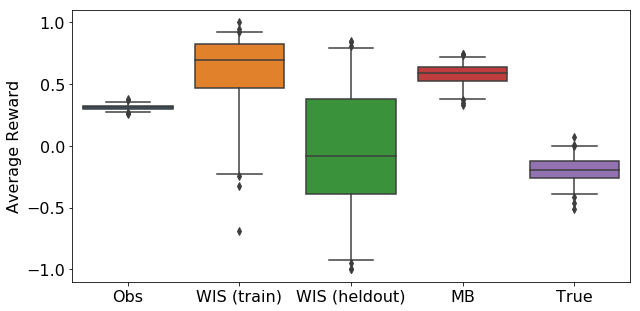

In [14]:
plt.rcParams.update({'font.size': 16})
reward = np.concatenate([obs_reward, 
                         offpol_opt_reward_WIS_hard_train,
                         offpol_opt_reward_WIS_hard_ho,                         
                         offpol_opt_reward_mb,
                         true_rl_reward,
                         ], axis=1)
reward_df = pd.DataFrame(reward, columns=['Obs', 
                                          'WIS (train)',
                                          'WIS (heldout)',                                          
                                          'MB',
                                          'True'
                                         ])

plt.figure(figsize=(10,5))
sns.boxplot(data=reward_df, whis=[2.5, 97.5])
plt.ylabel("Average Reward")
plt.savefig("{}/{}-ope_wis_mb_cf_true.pdf".format(
    figpath, fig_prefix), bbox_inches='tight')
plt.show()

In [15]:
print(("RESULTS:"
       "\n\tObserved Reward:  {:.4f} \t 95% Range: {:.4f} to {:.4f}"
       "\n\tTrue RL Reward:\t {:.4f} \t 95% Range: {:.4f} to {:.4f}"
       "\n\tWIS (train) :\t {:.4f} \t 95% Range: {:.4f} to {:.4f}"
       "\n\tWIS (heldout) :\t {:.4f} \t 95% Range: {:.4f} to {:.4f}"
       "\n\tMB Estimate:\t {:.4f} \t 95% Range: {:.4f} to {:.4f}"
      ).format(
    obs_reward.mean(), 
    np.quantile(obs_reward, 0.025), 
    np.quantile(obs_reward, 0.975), 
    true_rl_reward.mean(), 
    np.quantile(true_rl_reward,0.025), 
    np.quantile(true_rl_reward, 0.975),
    offpol_opt_reward_WIS_hard_train.mean(), 
    np.quantile(offpol_opt_reward_WIS_hard_train,0.025), 
    np.quantile(offpol_opt_reward_WIS_hard_train,0.975),
    offpol_opt_reward_WIS_hard_ho.mean(), 
    np.quantile(offpol_opt_reward_WIS_hard_ho,0.025), 
    np.quantile(offpol_opt_reward_WIS_hard_ho,0.975),
    offpol_opt_reward_mb.mean(), 
    np.quantile(offpol_opt_reward_mb,0.025), 
    np.quantile(offpol_opt_reward_mb,0.975)
))

RESULTS:
	Observed Reward:  0.3097 	 95% Range: 0.2694 to 0.3510
	True RL Reward:	 -0.1930 	 95% Range: -0.4051 to -0.0004
	WIS (train) :	 0.5804 	 95% Range: -0.2336 to 0.9235
	WIS (heldout) :	 -0.0372 	 95% Range: -0.9379 to 0.7991
	MB Estimate:	 0.5779 	 95% Range: 0.3738 to 0.7270
